In [1]:
%matplotlib inline
import numpy as np
import scipy.special as sc
from scipy import stats
import scipy.linalg as scalg
import matplotlib.pyplot as plt
import pdb
from deprojectVis import deproject_vis
from scipy.linalg import cho_factor, cho_solve

In [2]:
#Squared exponential kernel
def exp2kernel(i1, i2, ibins=None, a=None, l=None):
    ri = ibins[i1]
    rj = ibins[i2]
    tol = 1e-6
    nugget = np.zeros_like(ri)
    nugget[(ri-rj)<tol] = 1e-16 #AD HOC!        
    return a*a * np.exp(-((ri - rj)**2.)/(2.*l*l))+nugget

#Covariance matrix for intensities
def calccovar(binsin, ain, lin):
    '''
    Calculate the covariance matrix using a squared exponential kernel
    a: normalization amplitude
    l: correlation length
    '''
    nbins = binsin.shape[0]
    cov = np.fromfunction(exp2kernel,(nbins,nbins), ibins=binsin, a=ain, l=lin, dtype = np.int)
    return cov


In [3]:
##1 - Data setup
##We have Ndata data visibilities (D), with covariance matrix Sigma

#1a. Read in visibility data
visfilename = 'DATA/fullA_nf_discrete.vis.npz' ##Set
datfile = np.load(visfilename)
Dorig = datfile['Vis']
uorig = datfile['u']
vorig = datfile['v']
rhoorig = np.sqrt(uorig**2. + vorig**2.)
Dwgtorig = datfile['Wgt']
#Sigmainv = np.diag(Dwgtorig) #a little unnecessary

#1b. Deproject (and optionally bin) the visibilities so that they're face-on
incl = 50. #deg
PA = 70. #deg
offx = -0.3 #arcsec
offy = -0.2 #arcsec
#visbins = np.arange(1., np.amax(rhoorig)/1000, 10) #Visibility bins
nvisbins = 100. ##Set
if (nvisbins>1):
   #visbins = np.linspace(np.amin(rhoorig)/1000., np.amax(rhoorig)/1000., nvisbins)
   #!!MAY NEED CHANGING!!
   visbins = stats.mstats.mquantiles(rhoorig/1000, np.arange(nvisbins)/nvisbins) #Changing the bins to have roughly even numbers of visibilities in each        
   rhodeproj, Ddeproj, sigdeproj = deproject_vis([uorig, vorig, Dorig, Dwgtorig], visbins, incl, PA, offx, offy, errtype='scat')
else:
   rhodeproj, Ddeproj, sigdeproj = deproject_vis([uorig, vorig, Dorig, Dwgtorig], incl=incl, PA=PA, offx=offx, offy=offy)

#1c. Set data variables (currently only using real parts)
arcsec = 180./np.pi*3600.
D = Ddeproj.real
rho = rhodeproj/arcsec #units of 1/arcsec
Sigmainv = np.diag(1./np.square(sigdeproj.real))
Ndata = D.size
print 'Number of vis is', Ndata, np.shape(rho), np.shape(Sigmainv)

Number of vis is 100 (100,) (100, 100)


In [62]:
##2 - Model Setup
##We have a model visibility (M) which uses Nbins annuli

#Select model annuli radii in arcsec
rmin = 0.01/140.
rmax = 1.1
Nbins = 50
radii = np.linspace(rmin, rmax, num=Nbins+1) #Currently does NOT use rin
rleft = radii[:-1]
rright = radii[1:]
rcenter = (rleft+rright)/2.

#M=Xw, where X is only a function of the bins and baselines
X = np.empty([Ndata,Nbins])
for j in range(Ndata):
    for i in range(Nbins):
        X[j][i] = 1./rho[j]*(rright[i]*sc.j1(rho[j]*2.*np.pi*rright[i]) - rleft[i]*sc.j1(rho[j]*2.*np.pi*rleft[i]))

In [63]:
##3 - Compute linear algebra

#Calculate uniform prior mean and covariance matrix
#The mean of the distribution with a uniform prior is wu, with covariance Cu
Cu = np.dot(np.dot(X.T, Sigmainv), X)
#Alternate method without inverse
wu = np.linalg.solve(Cu, np.dot(np.dot(X.T, Sigmainv), D)) #better than wu0

In [64]:
#Calculate the mean to use for GP kernel (for now it's the truth)
flux = 0.12
sig = 0.6
incl = 50.
PA = 70.
offx = -0.3
offy = -0.2
nominal_SB = (sig/rcenter)**0.7 * np.exp(-(rcenter/sig)**2.5)	# fullA distribution
int_SB = np.trapz(2.*np.pi*nominal_SB*rcenter, rcenter)		# a check on the total flux
nominal_SB *= flux / int_SB

muw = nominal_SB #Truth

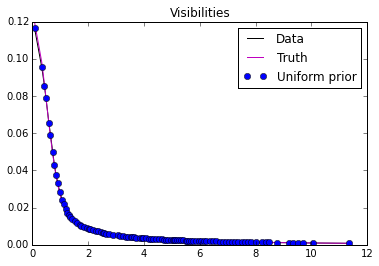

In [65]:
#Plot visibilities to compare data, truth, and uniform output
plt.plot(rho, D, '-k', label='Data')
plt.plot(rho, np.dot(X, nominal_SB), '-m', label= 'Truth')
plt.plot(rho, np.dot(X, wu), 'ob', label='Uniform prior')
plt.title('Visibilities')
plt.legend()

!!This tends to look better for smaller Ndata, suggesting there still may be an issue with wu calculation!!


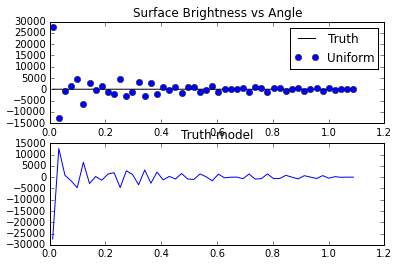

In [66]:
#Plot SB to compare data, truth, and uniform output
plt.subplot(211)
plt.plot(rcenter, nominal_SB, '-k', label='Truth')
plt.plot(rcenter, wu, 'ob', label='Uniform')
plt.legend()
plt.title ('Surface Brightness vs Angle')
plt.subplot(212)
plt.plot(rcenter, nominal_SB - wu)
plt.title('Truth-model')
print "!!This tends to look better for smaller Ndata, suggesting there still may be an issue with wu calculation!!"

In [67]:
#Calculate the GP covariance matrix (Cw) from the kernel (k), with mean muw
#The mean of the distribution with this prior is wgp, with variance Cgp
gpa = 1. #Hyperparameter amplitude
gpl = .05 #Hyperparameter lengthscale
Cw = calccovar(rcenter, gpa, gpl)
Cwinv = np.linalg.inv(calccovar(rcenter, gpa, gpl))

<matplotlib.colorbar.Colorbar instance at 0x114b6b200>

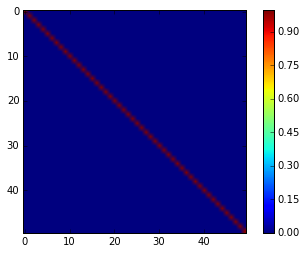

In [68]:
plt.imshow(np.dot(Cw, Cwinv))
plt.colorbar()
#If it doesn't look like the identity matrix, something is wrong! Check nugget term in kernel.

In [69]:
#Non-inverse method to getting wgp
Cgpinv = np.linalg.solve(Cu, np.eye(Nbins) + np.dot(Cu, Cwinv))
Cuinvwu = np.linalg.solve(Cu, wu)
wgp = np.linalg.solve(Cgpinv, Cuinvwu + np.dot(Cwinv, muw))

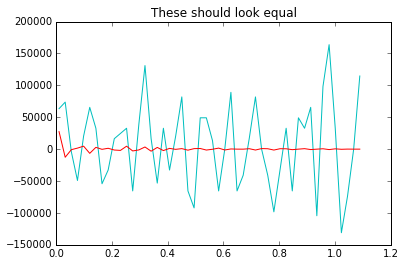

In [70]:
plt.plot(rcenter, np.dot(Cu, Cuinvwu), 'c') #Cu.inv(Cu).wu
plt.plot(rcenter, wu, 'r') #wu
plt.title('These should look equal')


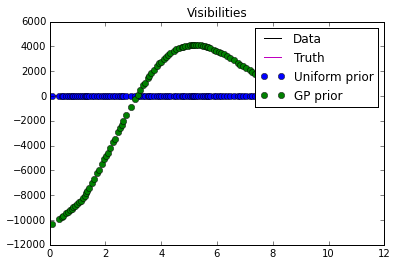

In [71]:
#Plot visibilities
plt.plot(rho, D, '-k', label='Data')
plt.plot(rho, np.dot(X, nominal_SB), '-m', label= 'Truth')
plt.plot(rho, np.dot(X, wu), 'ob', label='Uniform prior')
plt.plot(rho, np.dot(X, wgp), 'og', label='GP prior')
plt.title('Visibilities')
plt.legend()

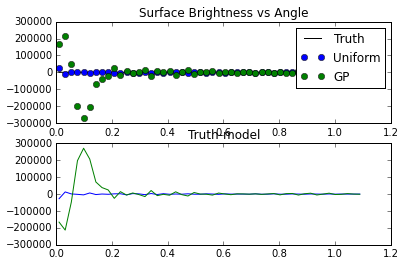

In [72]:
#Plot SB
plt.subplot(211)
plt.plot(rcenter, nominal_SB, '-k', label='Truth')
plt.plot(rcenter, wu, 'ob', label='Uniform')
plt.plot(rcenter, wgp, 'og', label='GP')
plt.legend()
plt.title ('Surface Brightness vs Angle')
plt.subplot(212)
plt.plot(rcenter, nominal_SB - wu,'-b')
plt.plot(rcenter, nominal_SB - wgp, '-g')
plt.title('Truth-model')

#The Old Method That Uses Inverses

In [73]:
#The regular inverse way of doing all of this:
Cuinv0 = np.linalg.inv(Cu)
wu0 = np.dot(Cuinv0, np.dot(np.dot(X.T, Sigmainv), D)) 
Cgp0 = np.linalg.inv(Cuinv0+Cwinv)
wgp0 = np.dot(Cgp0,(np.dot(Cuinv0, wu0) + np.dot(Cwinv, muw)))

Cuinv0 does not work well


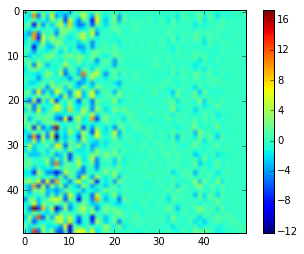

In [74]:
#Checking Cuinv0
plt.imshow(np.dot(Cu,Cuinv0))
plt.colorbar()
print 'Cuinv0 does not work well'

Truth [  1.28498534e+00   5.96944721e-01   4.16969411e-01   3.28448811e-01
   2.74085683e-01   2.36477369e-01   2.08409488e-01   1.86316564e-01
   1.68223242e-01   1.52943951e-01   1.39724185e-01   1.28062162e-01
   1.17612820e-01   1.08132756e-01   9.94469535e-02   9.14277696e-02
   8.39811504e-02   7.70372775e-02   7.05440305e-02   6.44622932e-02
   5.87625062e-02   5.34220832e-02   4.84234455e-02   4.37525097e-02
   3.93975180e-02   3.53481344e-02   3.15947527e-02   2.81279762e-02
   2.49382393e-02   2.20155487e-02   1.93493230e-02   1.69283157e-02
   1.47406067e-02   1.27736487e-02   1.10143572e-02   9.44923145e-03
   8.06449799e-03   6.84626539e-03   5.78068351e-03   4.85409902e-03
   4.05320180e-03   3.36515700e-03   2.77771945e-03   2.27932797e-03
   1.85917827e-03   1.50727427e-03   1.21445842e-03   9.72422440e-04
   7.73700401e-04   6.11646428e-04]
With solve [  2.74496672e+04  -1.27082124e+04  -8.36436978e+02   1.61493208e+03
   4.67895161e+03  -6.58312133e+03   2.81548948e+0

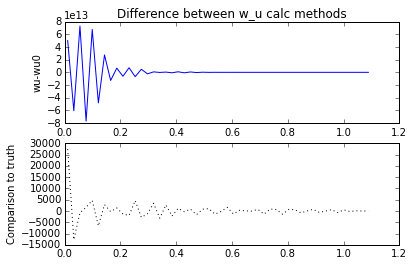

In [75]:
#Compare wu and wu0
print 'Truth', nominal_SB
print 'With solve', wu
print 'With inv', wu0
plt.subplot(211)
plt.plot(rcenter, wu-wu0)
plt.title('Difference between w_u calc methods')
plt.ylabel('wu-wu0')
plt.subplot(212)
plt.plot(rcenter, wu-nominal_SB, ':k', label='Truth')
plt.ylabel('Comparison to truth')


This should look like the identity matrix, but it depends strongly on the hyperparameters.


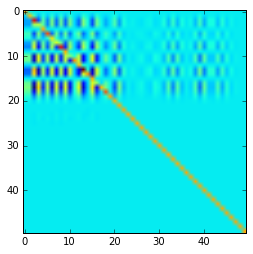

In [76]:
#Look at Cgp and Cgpinv
plt.imshow(np.dot(Cgp0, (Cuinv0+Cwinv)))
print 'This should look like the identity matrix, but it depends strongly on the hyperparameters.'

In [77]:
np.linalg.cond(Cu)/1e16

46.799088654325992

201866.822651


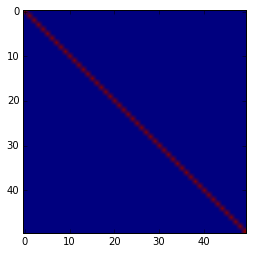

In [78]:
print np.amin(np.diag(Cu))
Cueps = Cu + np.eye(Nbins)*10.
np.linalg.cond(Cueps)/1e6
Cuepsinv = np.linalg.inv(Cueps)
plt.imshow(np.dot(Cueps, Cuepsinv))

In [79]:
wueps = np.dot(Cuepsinv, np.dot(np.dot(X.T, Sigmainv), D)) 
Cgpeps = np.linalg.inv(Cuepsinv+Cwinv)
wgpeps = np.dot(Cgpeps,(np.dot(Cuepsinv, wueps) + np.dot(Cwinv, muw)))

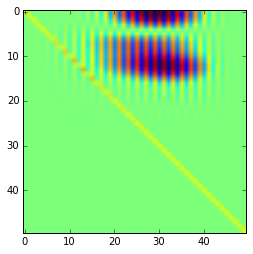

In [80]:
plt.imshow(np.dot(Cgpeps,Cuepsinv+Cwinv))

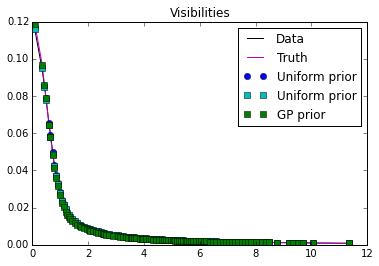

In [81]:
#Plot visibilities
plt.plot(rho, D, '-k', label='Data')
plt.plot(rho, np.dot(X, nominal_SB), '-m', label= 'Truth')
plt.plot(rho, np.dot(X, wu), 'ob', label='Uniform prior')
plt.plot(rho, np.dot(X, wueps), 'sc', label='Uniform prior')
#plt.plot(rho, np.dot(X, wgp), 'or', label='GP prior')
plt.plot(rho, np.dot(X, wgpeps), 'sg', label='GP prior')
plt.title('Visibilities')
plt.legend()

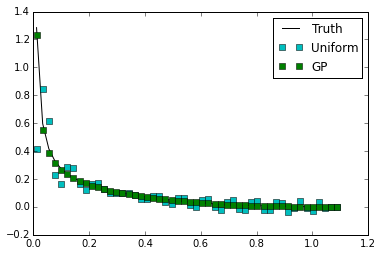

In [82]:
plt.plot(rcenter, nominal_SB, '-k', label='Truth')
#plt.plot(rcenter, wu, 'ob', label='Uniform')
plt.plot(rcenter, wueps, 'sc', label='Uniform')
#plt.plot(rcenter, wgp, 'or', label='GP')
plt.plot(rcenter, wgpeps, 'sg', label='GP')
plt.legend()

In [61]:
rcenter[2]-rcenter[1]

0.010999285714285715

In [83]:
nominal_SB-wgpeps

array([  5.29940516e-02,   4.27132490e-02,   2.77859040e-02,
         1.47748901e-02,   6.56783905e-03,   2.45862181e-03,
         7.64915975e-04,   2.80907873e-04,   2.37632217e-04,
         1.96520961e-04,   1.08498898e-04,   9.38151258e-05,
         1.45358588e-04,   1.50154885e-04,   8.26049641e-05,
         2.90676371e-05,   4.31235250e-05,   6.99120121e-05,
         4.30733022e-05,  -3.51861437e-06,   5.20274712e-06,
         4.74802054e-05,   3.66586307e-05,  -1.75694045e-05,
        -1.90671490e-05,   3.37826202e-05,   3.84915241e-05,
        -1.68456048e-05,  -2.82415515e-05,   2.23918842e-05,
         3.19183201e-05,  -2.05751092e-05,  -3.46566216e-05,
         1.08131949e-05,   2.04663706e-05,  -2.43014700e-05,
        -3.52560715e-05,   1.63117772e-06,   7.54746807e-06,
        -2.55877528e-05,  -3.04671393e-05,  -5.08360120e-06,
        -3.57220979e-06,  -2.31228309e-05,  -2.34611780e-05,
        -9.86675907e-06,  -9.48909534e-06,  -1.69194122e-05,
        -1.55992751e-05,